# Pedro y el Lobo: Introducción al Aprendizaje por Refuerzo

En este tutorial, aprenderemos cómo aplicar el aprendizaje por refuerzo a un problema de búsqueda de caminos. El escenario está inspirado en el cuento musical [Pedro y el Lobo](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) del compositor ruso [Sergei Prokofiev](https://en.wikipedia.org/wiki/Sergei_Prokofiev). Es la historia de un joven pionero, Pedro, que valientemente sale de su casa hacia el claro del bosque para perseguir al lobo. Entrenaremos algoritmos de aprendizaje automático que ayudarán a Pedro a explorar el área circundante y a construir un mapa de navegación óptimo.

Primero, importemos un conjunto de bibliotecas útiles:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## Descripción general del Aprendizaje por Refuerzo

**Aprendizaje por Refuerzo** (RL) es una técnica de aprendizaje que nos permite aprender el comportamiento óptimo de un **agente** en algún **entorno** mediante la realización de muchos experimentos. Un agente en este entorno debe tener algún **objetivo**, definido por una **función de recompensa**.

## El Entorno

Para simplificar, consideremos el mundo de Peter como un tablero cuadrado de tamaño `width` x `height`. Cada celda en este tablero puede ser:
* **suelo**, sobre el cual Peter y otras criaturas pueden caminar
* **agua**, sobre la cual obviamente no se puede caminar
* **un árbol** o **hierba** - un lugar donde puedes descansar un poco
* **una manzana**, que representa algo que Peter estaría encantado de encontrar para alimentarse
* **un lobo**, que es peligroso y debe evitarse

Para trabajar con el entorno, definiremos una clase llamada `Board`. Para no sobrecargar demasiado este cuaderno, hemos movido todo el código relacionado con el tablero a un módulo separado llamado `rlboard`, que ahora importaremos. Puedes mirar dentro de este módulo para obtener más detalles sobre los aspectos internos de la implementación.


In [2]:
from rlboard import *

Ahora creemos un tablero aleatorio y veamos cómo se ve:


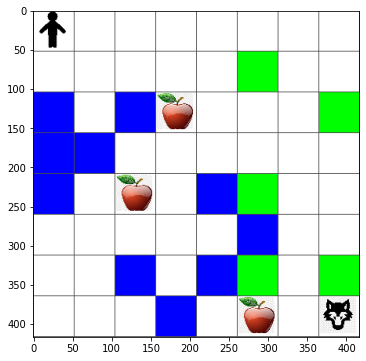

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## Acciones y Política

En nuestro ejemplo, el objetivo de Peter sería encontrar una manzana, mientras evita al lobo y otros obstáculos. Para lograr esto, básicamente puede caminar hasta encontrar una manzana. Por lo tanto, en cualquier posición puede elegir entre una de las siguientes acciones: arriba, abajo, izquierda y derecha. Definiremos esas acciones como un diccionario y las asignaremos a pares de cambios de coordenadas correspondientes. Por ejemplo, moverse hacia la derecha (`R`) correspondería a un par `(1,0)`.


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

La estrategia de nuestro agente (Peter) está definida por una **política**. Consideremos la política más simple llamada **camino aleatorio**.

## Camino aleatorio

Primero resolvamos nuestro problema implementando una estrategia de camino aleatorio.


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

Hagamos el experimento de caminata aleatoria varias veces y veamos el número promedio de pasos tomados:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## Función de Recompensa

Para hacer que nuestra política sea más inteligente, necesitamos entender qué movimientos son "mejores" que otros.


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Aprendizaje Q

Construye una Q-Table, o un array multidimensional. Dado que nuestro tablero tiene dimensiones `width` x `height`, podemos representar la Q-Table con un array de numpy con la forma `width` x `height` x `len(actions)`:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Pasa la Q-Table a la función de trazado para visualizar la tabla en el tablero:


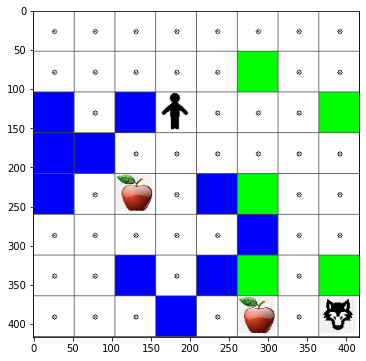

In [9]:
m.plot(Q)

## Esencia del Q-Learning: Ecuación de Bellman y Algoritmo de Aprendizaje

Escribe un pseudocódigo para nuestro algoritmo de aprendizaje:

* Inicializa la tabla Q (Q-Table) con valores iguales para todos los estados y acciones
* Establece la tasa de aprendizaje $\alpha\leftarrow 1$
* Repite la simulación muchas veces
   1. Comienza en una posición aleatoria
   1. Repite
        1. Selecciona una acción $a$ en el estado $s$
        2. Ejecuta la acción moviéndote a un nuevo estado $s'$
        3. Si encontramos una condición de fin de juego, o la recompensa total es demasiado baja, sal de la simulación  
        4. Calcula la recompensa $r$ en el nuevo estado
        5. Actualiza la función Q de acuerdo con la ecuación de Bellman: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. Actualiza la recompensa total y disminuye $\alpha$.

## Explotar vs. Explorar

El mejor enfoque es equilibrar entre exploración y explotación. A medida que aprendemos más sobre nuestro entorno, es más probable que sigamos la ruta óptima, aunque de vez en cuando elijamos un camino no explorado.

## Implementación en Python

Ahora estamos listos para implementar el algoritmo de aprendizaje. Antes de eso, también necesitamos una función que convierta números arbitrarios en la tabla Q (Q-Table) en un vector de probabilidades para las acciones correspondientes:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Agregamos una pequeña cantidad de `eps` al vector original para evitar la división por 0 en el caso inicial, cuando todos los componentes del vector son idénticos.

El algoritmo de aprendizaje que ejecutaremos en 5000 experimentos, también llamados **épocas**:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

Después de ejecutar este algoritmo, la Tabla-Q debería actualizarse con valores que definan la atractividad de diferentes acciones en cada paso. Visualiza la tabla aquí:


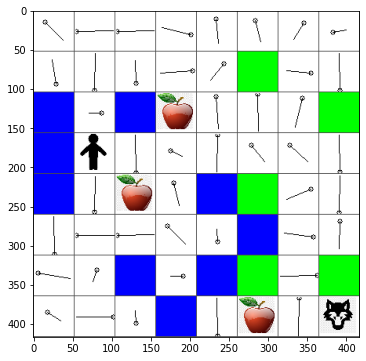

In [12]:
m.plot(Q)

## Verificando la Política

Dado que la Q-Table enumera la "atractividad" de cada acción en cada estado, es bastante fácil usarla para definir la navegación eficiente en nuestro mundo. En el caso más simple, podemos simplemente seleccionar la acción que corresponde al valor más alto en la Q-Table:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

Si pruebas el código anterior varias veces, puedes notar que a veces simplemente se "queda colgado", y necesitas presionar el botón de DETENER en el notebook para interrumpirlo.

> **Tarea 1:** Modifica la función `walk` para limitar la longitud máxima del camino a un cierto número de pasos (por ejemplo, 100), y observa cómo el código anterior devuelve este valor de vez en cuando.

> **Tarea 2:** Modifica la función `walk` para que no regrese a los lugares donde ya ha estado previamente. Esto evitará que `walk` entre en bucles, sin embargo, el agente aún puede terminar "atrapado" en una ubicación de la que no pueda escapar.


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


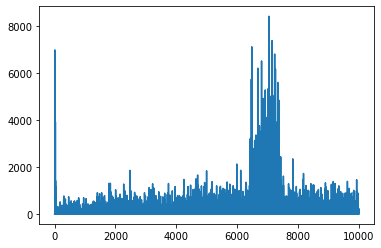

In [15]:
plt.plot(lpath)

Lo que observamos aquí es que, al principio, la longitud promedio del camino aumentó. Esto probablemente se deba al hecho de que, cuando no sabemos nada sobre el entorno, es más probable que quedemos atrapados en estados desfavorables, como agua o lobos. A medida que aprendemos más y comenzamos a usar este conocimiento, podemos explorar el entorno durante más tiempo, pero aún no sabemos bien dónde están las manzanas.

Una vez que aprendemos lo suficiente, se vuelve más fácil para el agente alcanzar el objetivo, y la longitud del camino comienza a disminuir. Sin embargo, seguimos abiertos a la exploración, por lo que a menudo nos desviamos del mejor camino y exploramos nuevas opciones, lo que hace que el camino sea más largo de lo óptimo.

Lo que también observamos en este gráfico es que, en algún momento, la longitud aumentó abruptamente. Esto indica la naturaleza estocástica del proceso y que, en algún punto, podemos "estropear" los coeficientes de la Q-Table al sobrescribirlos con nuevos valores. Idealmente, esto debería minimizarse disminuyendo la tasa de aprendizaje (es decir, hacia el final del entrenamiento solo ajustamos los valores de la Q-Table en pequeñas cantidades).

En general, es importante recordar que el éxito y la calidad del proceso de aprendizaje dependen significativamente de los parámetros, como la tasa de aprendizaje, la disminución de la tasa de aprendizaje y el factor de descuento. Estos a menudo se denominan **hiperparámetros**, para distinguirlos de los **parámetros** que optimizamos durante el entrenamiento (por ejemplo, los coeficientes de la Q-Table). El proceso de encontrar los mejores valores de hiperparámetros se llama **optimización de hiperparámetros**, y merece un tema aparte.


## Ejercicio
#### Un Mundo Más Realista de Pedro y el Lobo

En nuestra situación, Pedro podía moverse casi sin cansarse ni tener hambre. En un mundo más realista, tiene que sentarse y descansar de vez en cuando, y también alimentarse. Hagamos nuestro mundo más realista implementando las siguientes reglas:

1. Al moverse de un lugar a otro, Pedro pierde **energía** y gana algo de **fatiga**.
2. Pedro puede recuperar energía comiendo manzanas.
3. Pedro puede deshacerse de la fatiga descansando bajo el árbol o en la hierba (es decir, caminando hacia una ubicación en el tablero con un árbol o hierba - campo verde).
4. Pedro necesita encontrar y matar al lobo.
5. Para matar al lobo, Pedro necesita tener ciertos niveles de energía y fatiga, de lo contrario pierde la batalla.

Modifica la función de recompensa anterior de acuerdo con las reglas del juego, ejecuta el algoritmo de aprendizaje por refuerzo para aprender la mejor estrategia para ganar el juego y compara los resultados del paseo aleatorio con tu algoritmo en términos de número de juegos ganados y perdidos.

> **Nota**: Es posible que necesites ajustar los hiperparámetros para que funcione, especialmente el número de épocas. Dado que el éxito del juego (enfrentar al lobo) es un evento raro, puedes esperar un tiempo de entrenamiento mucho más largo.



---

**Descargo de responsabilidad**:  
Este documento ha sido traducido utilizando el servicio de traducción automática [Co-op Translator](https://github.com/Azure/co-op-translator). Si bien nos esforzamos por lograr precisión, tenga en cuenta que las traducciones automáticas pueden contener errores o imprecisiones. El documento original en su idioma nativo debe considerarse como la fuente autorizada. Para información crítica, se recomienda una traducción profesional realizada por humanos. No nos hacemos responsables de malentendidos o interpretaciones erróneas que puedan surgir del uso de esta traducción.
